<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.14.01.Colab_LandCover_WorldCover_10m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESA WorldCover Classification

The European Space Agency (ESA) WorldCover product provides a global land cover map for the year 2020 at 10-meters resolution based on Sentinel-1 and Sentinel-2 data. The WorldCover product comes with 11 land cover classes and has been generated in the framework of the ESA WorldCover project, part of the 5th Earth Observation Envelope Programme (EOEP-5) of the European Space Agency. This data can be found in the Google Earth Engine database as "ESA/WorldCover/v100". 

## Instructions for Execution

It is suggested that users first execute the notebook "as is" to successfully complete the Google authorizations and view sample results. Then, users should look for the "MODIFY HERE" label at the top of the 3rd code block. This is where the user defines the region of interest. 

Once the full notebook has been run, users can run individual code blocks using "Shift-Return" or run segments of the code using the Runtime menu. Users do not have to go thru the Google authorization steps for additional execution cycles. 

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

In [ ]:
from odc_colab import populate_db
populate_db()

In [1]:
from odc_gee.earthengine import Datacube
dc = Datacube(app='ESA_WorldCover')

from matplotlib.colors import ListedColormap, BoundaryNorm
from utils.data_cube_utilities.dc_display_map import display_map
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the product name
# This data is indexed from Google Earth Engine data sources
product = 'esa_worldcover_google'

In [3]:
# MODIFY HERE

# Select a Latitude-Longitude point for the center of the analysis region
# Select the size of the box (in degrees) surrounding the center point

# Kumasi, Ghana 
lat_long = (6.7, -1.6)
box_size_deg = 0.50

# Calculates the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

In [4]:
# Define the year of dataset (currently only 2020)
time = '2020'

In [5]:
# The code below renders a map that can be used to view the region.
display_map(latitude,longitude)

## Load the dataset

In [6]:
dataset = dc.load(product=product,time=time,latitude=latitude,longitude=longitude)

In [7]:
# Show the dimensions of the dataset
# The latitude and longitude bounds are in pixels
# The time index is in years (only one year currently available)
dataset

<xarray.Dataset>
Dimensions:      (latitude: 5567, longitude: 5567, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01
  * latitude     (latitude) float64 6.95 6.95 6.95 6.95 ... 6.45 6.45 6.45 6.45
  * longitude    (longitude) float64 -1.85 -1.85 -1.85 ... -1.35 -1.35 -1.35
    spatial_ref  int32 4326
Data variables:
    Map          (time, latitude, longitude) uint8 50 50 50 50 ... 60 60 60 10
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

### Create labels
The product comes with `flags_definition` metadata. GEE can also supply more metadata from the STAC API such as color coding. This can be used to create a labeled colormap. Note, `get_stac_metadata` method is only available for use on the custom `odc_gee.earthengine.Datacube` wrapper.

In [8]:
stac_metadata = dc.get_stac_metadata('ESA/WorldCover/v100')

flags = {0: 'nodata'}
flags.update({int(list(val['values'].keys())[0]): key\
         for key, val in dataset['Map'].flags_definition.items()})

labels = {0: dict(color='#000000', flag=flags[0])}
labels.update({_class['value']: dict(color=f'#{_class["color"]}',flag=flags[_class['value']])\
          for _class in stac_metadata['summaries']['eo:bands'][0]['gee:classes']})
colors = [label['color'] for label in labels.values()]

### Create color map

In [9]:
cmap = ListedColormap([label['color'] for label in labels.values()])
norm = BoundaryNorm(list(labels.keys())+[101], cmap.N+1, extend='max')
ticks = list(np.mean((list(list(labels.keys())+[101])[i+1], val)) for i, val in enumerate(list(labels.keys())))

### Plot the data

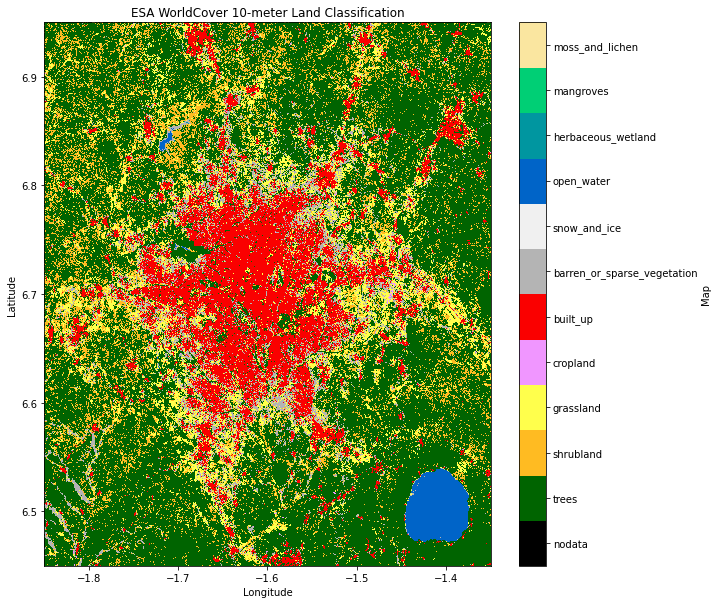

In [10]:
aspect = dataset.dims['longitude']/dataset.dims['latitude']
fig = dataset['Map'].isel(time=0).plot.imshow(cmap=cmap,
                                              size=10,norm=norm,cbar_kwargs=dict(ticks=ticks),aspect=aspect)
cbar = fig.colorbar
cbar.ax.set_yticklabels(labels=[label['flag'] for label in labels.values()])
plt.title('ESA WorldCover 10-meter Land Classification')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Statistics

In [11]:
print('\033[1;4mTotal number of pixels for each classification in defined region\033[0m')
for val, label in labels.items():
    print(f'{label["flag"]}: {np.sum(dataset.Map.isel(time=0).values == val)}')
    
print('\n\033[1;4mPercent of total pixel area in defined region\033[0m')
for val, label in labels.items():
    area = np.sum(dataset.Map.isel(time=0).values == val)\
           /dataset.Map.isel(time=0).size * 100
    print(f'{label["flag"]}: {round(area, 2)}%')

Total number of pixels for each classification in defined region
nodata: 0
trees: 17346980
shrubland: 3518945
grassland: 3202418
cropland: 71424
built_up: 4347204
barren_or_sparse_vegetation: 2012351
snow_and_ice: 0
open_water: 490863
herbaceous_wetland: 1304
mangroves: 0
moss_and_lichen: 0

Percent of total pixel area in defined region
nodata: 0.0%
trees: 55.97%
shrubland: 11.35%
grassland: 10.33%
cropland: 0.23%
built_up: 14.03%
barren_or_sparse_vegetation: 6.49%
snow_and_ice: 0.0%
open_water: 1.58%
herbaceous_wetland: 0.0%
mangroves: 0.0%
moss_and_lichen: 0.0%
